### Imports

In [23]:
import random
import os
import numpy as np
from glob import glob
from matplotlib import pyplot as plt
import pandas as pd
from torchvision.io import read_image
from torchvision import models
import torch
import copy
import neptune
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm.autonotebook import tqdm 
import seaborn as sns

plt.rcParams["figure.figsize"] = (8,8)

In [2]:
"""
Collection of functions which enable the evaluation of a classifier's performance,
by showing confusion matrix, accuracy, recall, precision etc.
"""

import numpy as np
import sys

import matplotlib.pyplot as plt

from sklearn import metrics
from tabulate import tabulate
import math
import logging
from datetime import datetime

def plot_confusion_matrix(ConfMat, label_strings=None, title='Confusion matrix', cmap=plt.cm.get_cmap('Blues')):
    """Plot confusion matrix in a separate window"""
    plt.imshow(ConfMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if label_strings:
        tick_marks = np.arange(len(label_strings))
        plt.xticks(tick_marks, label_strings, rotation=90)
        plt.yticks(tick_marks, label_strings)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def generate_classification_report(existing_class_names, precision, recall, f1, support, ConfMatrix_normalized_row, digits=3, number_of_thieves=2, maxcharlength=35):
    """
    Returns a string of a report for given metric arrays (array length equals the number of classes).
    Called internally by `analyze_classification`.
        digits: number of digits after . for displaying results
        number_of_thieves: number of biggest thieves to report
        maxcharlength: max. number of characters to use when displaying thief names
    """

    relative_freq = support / np.sum(support)  # relative frequencies of each class in the true lables
    sorted_class_indices = np.argsort(relative_freq)[
                            ::-1]  # sort by "importance" of classes (i.e. occurance frequency)

    last_line_heading = 'avg / total'

    width = max(len(cn) for cn in existing_class_names)
    width = max(width, len(last_line_heading), digits)

    headers = ["precision", "recall", "f1-score", "rel. freq.", "abs. freq.", "biggest thieves"]
    fmt = '%% %ds' % width  # first column: class name
    fmt += '  '
    fmt += ' '.join(['% 10s' for _ in headers[:-1]])
    fmt += '|\t % 5s'
    fmt += '\n'

    headers = [""] + headers
    report = fmt % tuple(headers)
    report += '\n'

    for i in sorted_class_indices:
        values = [existing_class_names[i]]
        for v in (precision[i], recall[i], f1[i],
                    relative_freq[i]):  # v is NOT a tuple, just goes through this list 1 el. at a time
            values += ["{0:0.{1}f}".format(v, digits)]
        values += ["{}".format(support[i])]
        thieves = np.argsort(ConfMatrix_normalized_row[i, :])[::-1][
                    :number_of_thieves + 1]  # other class indices "stealing" from class. May still contain self
        thieves = thieves[thieves != i]  # exclude self at this point
        steal_ratio = ConfMatrix_normalized_row[i, thieves]
        thieves_names = [
            existing_class_names[thief][:min(maxcharlength, len(existing_class_names[thief]))] for thief
            in thieves]  # a little inefficient but inconsequential
        string_about_stealing = ""
        for j in range(len(thieves)):
            string_about_stealing += "{0}: {1:.3f},\t".format(thieves_names[j], steal_ratio[j])
        values += [string_about_stealing]

        report += fmt % tuple(values)

    report += '\n' + 100 * '-' + '\n'

    # compute averages/sums
    values = [last_line_heading]
    for v in (np.average(precision, weights=relative_freq),
                np.average(recall, weights=relative_freq),
                np.average(f1, weights=relative_freq)):
        values += ["{0:0.{1}f}".format(v, digits)]
    values += ['{0}'.format(np.sum(relative_freq))]
    values += ['{0}'.format(np.sum(support))]
    values += ['']

    # make last ("Total") line for report
    report += fmt % tuple(values)

    return report


def action_evaluator(y_pred, y_true, class_names, excluded_classes=None, maxcharlength=35, print_report=True, show_plot=True):
    """
    For an array of label predictions and the respective true labels, shows confusion matrix, accuracy, recall, precision etc:
    Input:
        y_pred: 1D array of predicted labels (class indices)
        y_true: 1D array of true labels (class indices)
        class_names: 1D array or list of class names in the order of class indices.
            Could also be integers [0, 1, ..., num_classes-1].
        excluded_classes: list of classes to be excluded from average precision, recall calculation (e.g. OTHER)
    """

    # Trim class_names to include only classes existing in y_pred OR y_true
    in_pred_labels = set(list(y_pred))
    in_true_labels = set(list(y_true))
    # print("predicted labels > ", in_pred_labels, "in_true_labels > ", in_true_labels)

    existing_class_ind = sorted(list(in_pred_labels | in_true_labels))
    # print("pred label", in_pred_labels, "true label", in_true_labels)
    class_strings = [str(name) for name in class_names]  # needed in case `class_names` elements are not strings
    existing_class_names = [class_strings[ind][:min(maxcharlength, len(class_strings[ind]))] for ind in existing_class_ind]  # a little inefficient but inconsequential

    # Confusion matrix
    ConfMatrix = metrics.confusion_matrix(y_true, y_pred)

    # Normalize the confusion matrix by row (i.e by the number of samples in each class)
    ConfMatrix_normalized_row = metrics.confusion_matrix(y_true, y_pred, normalize='true') 

    if show_plot:
        plt.figure()
        plot_confusion_matrix(ConfMatrix_normalized_row, label_strings=existing_class_names,
                                title='Confusion matrix normalized by row')
        plt.show(block=False)

    # Analyze results
    total_accuracy = np.trace(ConfMatrix) / len(y_true)
    print('Overall accuracy: {:.3f}\n'.format(total_accuracy))

    # returns metrics for each class, in the same order as existing_class_names
    precision, recall, f1, support = metrics.precision_recall_fscore_support(y_true, y_pred, labels=existing_class_ind, zero_division=0)
    # Print report
    if print_report:
        print(generate_classification_report(existing_class_names, precision, recall, f1, support, ConfMatrix_normalized_row))

    # Calculate average precision and recall
    # prec_avg, rec_avg = get_avg_prec_recall(ConfMatrix, existing_class_names, excluded_classes)
    # if excluded_classes:
    #     print(
    #         "\nAverage PRECISION: {:.2f}\n(using class frequencies as weights, excluding classes with no predictions and predictions in '{}')".format(
    #             prec_avg, ', '.join(excluded_classes)))
    #     print(
    #         "\nAverage RECALL (= ACCURACY): {:.2f}\n(using class frequencies as weights, excluding classes in '{}')".format(
    #             rec_avg, ', '.join(excluded_classes)))

    # Make a histogram with the distribution of classes with respect to precision and recall
    # prec_rec_histogram(precision, recall)

    return {"accuracy": total_accuracy, "precision": precision.mean(), "recall": recall.mean(), "f1": f1.mean()}

C:\Users\ACER\AppData\Local\Temp\ipykernel_2472\1246506326.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  def plot_confusion_matrix(ConfMat, label_strings=None, title='Confusion matrix', cmap=plt.cm.get_cmap('Blues')):


### Configs

In [28]:
TRAIN_DIR = "E:/GSOC/DeepLense/General Test/dataset/dataset/train"
VAL_DIR = "E:/GSOC/DeepLense/General Test/dataset/dataset//val"
SAVE_DIR = "E:/GSOC/DeepLense/General Test/model_saves"

config = {
    "test":"General Test",
    "experiment title":"MobileNetV3Small",
    "enviroment":"colab",
    "TRAIN_DIR":TRAIN_DIR,
    "VAL_DIR":VAL_DIR,
    "model":{},
    "n_epochs":50,
    "device":"gpu",
}

In [4]:
clsid2clsname = {}
clsname2clsid = {}

for i,fol in enumerate([x for x in os.listdir(TRAIN_DIR) if x[0] != "."]):
  clsid2clsname[i] = fol
  clsname2clsid[fol] = i

In [5]:
class StrongLensingDataset(Dataset):
    def __init__(self, img_dir, class2id,transform=None, target_transform=None, to_3d=False):
        self.paths = self.__read_data_dir(img_dir)
        self.img_dir = img_dir
        self.class2id = class2id
        self.transform = transform
        self.target_transform = target_transform
        self.to_3d = to_3d

    def __read_data_dir(self,img_dir:str)->pd.DataFrame:
      records = []
      for __f in glob(f"{img_dir}/*/*.npy"):
        records.append((__f,__f.split(os.path.sep)[-2]))

      return pd.DataFrame.from_records(data=records,columns=["path","label"])

    def __len__(self):
        return self.paths.shape[0]

    def __getitem__(self, idx):
        img_path = self.paths.iloc[idx, 0]
        image = np.load(img_path)
        
        if self.to_3d:
            image = np.vstack([image,image,image])
        label = self.paths.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, self.class2id[label]

In [6]:
#Dataset definition

train_ds = StrongLensingDataset(TRAIN_DIR,class2id=clsname2clsid,to_3d=True)
val_ds = StrongLensingDataset(VAL_DIR,class2id=clsname2clsid,to_3d=True)

In [7]:
# The dataset classes are balanced.

train_ds.paths["label"].value_counts(),val_ds.paths["label"].value_counts()

(no        10000
 sphere    10000
 vort      10000
 Name: label, dtype: int64,
 no        2500
 sphere    2500
 vort      2500
 Name: label, dtype: int64)

In [8]:
#DataLoader definition

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=True)

In [34]:
train_ds[0][0].shape

(3, 150, 150)

## Model 

In [9]:
pre_trained_model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights)

e:\GSOC\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
pre_trained_model.classifier[3]

Linear(in_features=1024, out_features=1000, bias=True)

In [11]:
class DeepLenseModel(nn.Module):
    def __init__(self,pretrain,num_class) -> None:
        super(DeepLenseModel,self).__init__()
        self.num_classes = num_class
        self.backbone = pretrain
        self.backbone.classifier[3] = nn.Linear(in_features=1024, out_features=3, bias=True)
    
    def forward(self,x):
        x = self.backbone(x)
        x = nn.functional.log_softmax(x,dim=1)
        return x
    

In [12]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
device

device(type='cuda', index=0)

In [13]:
model = DeepLenseModel(pretrain=pre_trained_model,num_class=3)

In [14]:
model(torch.rand((32,3,150,150))).size()

torch.Size([32, 3])

In [15]:
model.to(device);

## Train Configs


In [16]:
loss_modules = {"cross_entropy":nn.CrossEntropyLoss()}
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.1)

## Neptune AI

In [17]:
run = neptune.init_run(
    project="devindesilva/GSOC-DeepLense",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vbmV3LXVpLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9uZXctdWkubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4NzI1ZDQyMy05ZTJiLTQ3OGQtYTFiNC05ZGUwMjcyZGM2MzgifQ==",
)

e:\GSOC\.venv\lib\site-packages\neptune\common\warnings.py:62: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  warnings.warn(


https://new-ui.neptune.ai/devindesilva/GSOC-DeepLense/e/GSOC-11


In [18]:
def loss_fn(y_true,y_pred,loss_module,recorder=None):
  categorical_loss = loss_module['cross_entropy'](y_pred,y_true)
  return categorical_loss,{'cross_entropy':categorical_loss}

## Training Loop

In [33]:
def save_model(model,model_name,unique_name):
    PATH = f"{SAVE_DIR}/{model_name}"
    os.makedirs(PATH,exist_ok=True)
    torch.save({
        "n_epochs" : config["n_epochs"],
        "model_state_dict":model.state_dict(),
        "config": config
    }, f"{PATH}/{unique_name}.pt")
    

def train_step(model, dataloader, optimizer, loss_module, device, phase='train', l2_reg=False, loss_alpha=0.7):
    model = model.train()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets= batch
            X = X.float().to(device)
            targets = targets.long().to(device)

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                class_output = model(X)

            #loss = cross_entropy_loss
            loss, loss_details = loss_fn(targets,class_output,loss_module)

            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                total_samples += len(targets)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class using Argmax
            class_output = torch.argmax(class_output, dim=1)
            pred_class = class_output.cpu().detach().numpy()
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class)
            tepoch.set_postfix(metrics)

    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics

def eval_step(model, dataloader, loss_module, device, class_names,  phase='seen', l2_reg=False, print_report=True, loss_alpha=0.7):
    model = model.eval()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    per_batch = {'targets': [], 'predictions': [], 'metrics': []}
    metrics = {"samples": 0, "loss": 0, "cross_entropy": 0}

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets = batch
            X = X.float().to(device)
            targets = targets.long().to(device)

            # forward track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                class_output = model(X)
            
            loss, loss_details = loss_fn(targets,class_output,loss_module)

            class_output = torch.argmax(class_output, dim=1)
            pred_action = class_output
                

            with torch.no_grad():
                metrics['samples'] += len(targets)
                metrics['loss'] += loss.item()  # add total loss of batch
                metrics['cross_entropy'] += loss_details['cross_entropy']

            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action.cpu().numpy())
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})

    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets, class_names=class_names, print_report=print_report)
    metrics_dict.update(metrics)
    return metrics_dict

def log(fold, phase, metrics):
    for m, v in metrics.items():
        if fold == 'global':
            run[f'global/{m}'].log(v)
        else:
            run[f"Fold-{fold}/{phase}/{m}"].log(v) 

def plot_curves(df):
    df['loss'] = df['loss']/df['samples']
    df['cross_entropy. loss'] = df['cross_entropy. loss']/df['samples']
    
    fig, axs = plt.subplots(nrows=4)
    sns.lineplot(data=df, x='epoch', y='loss', hue='phase', marker='o', ax=axs[2]).set(title="Loss")
    sns.lineplot(data=df, x='epoch', y='cross_entropy. loss', hue='phase', marker='o', ax=axs[0]).set(title="Cross Entropy. Loss")
    sns.lineplot(data=df, x='epoch', y='accuracy', hue='phase', marker='o', ax=axs[3]).set(title="Accuracy")

Training Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

train:   0%|          | 0/938 [00:00<?, ?batch/s]

Exception in thread NeptuneWebhooks:
Traceback (most recent call last):
  File "e:\GSOC\.venv\lib\site-packages\websocket\_socket.py", line 108, in recv
    bytes_ = _recv()
  File "e:\GSOC\.venv\lib\site-packages\websocket\_socket.py", line 87, in _recv
    return sock.recv(bufsize)
  File "C:\Python39\lib\ssl.py", line 1226, in recv
    return self.read(buflen)
  File "C:\Python39\lib\ssl.py", line 1101, in read
    return self._sslobj.read(len)
TimeoutError: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Python39\lib\threading.py", line 973, in _bootstrap_inner
    self.run()
  File "e:\GSOC\.venv\lib\site-packages\neptune\internal\threading\daemon.py", line 53, in run
    self.work()
  File "e:\GSOC\.venv\lib\site-pac

val:   0%|          | 0/235 [00:00<?, ?batch/s]

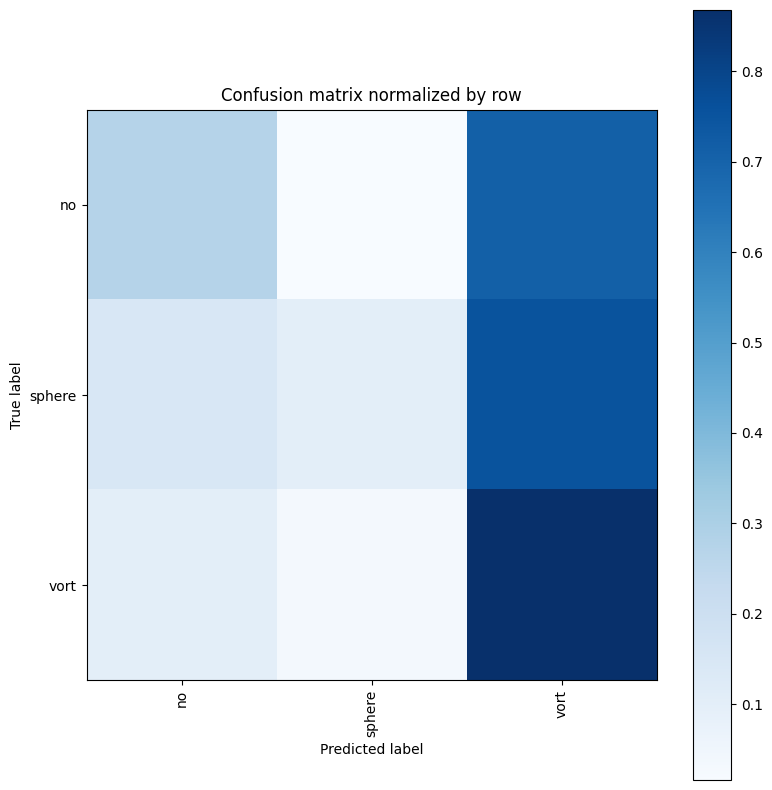

Overall accuracy: 0.413



train:   0%|          | 0/938 [00:00<?, ?batch/s]

val:   0%|          | 0/235 [00:00<?, ?batch/s]

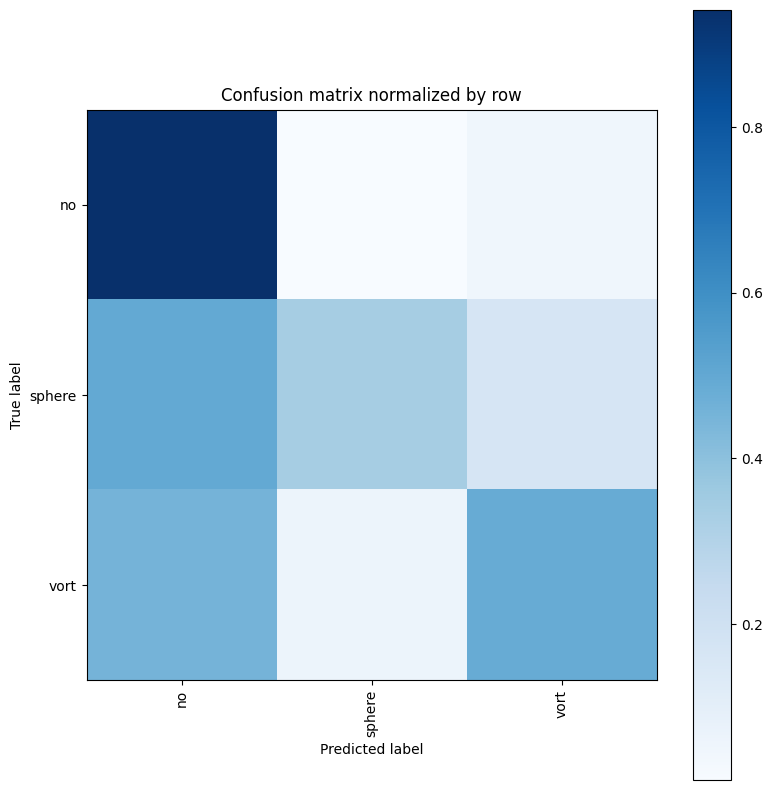

Overall accuracy: 0.588



train:   0%|          | 0/938 [00:00<?, ?batch/s]

val:   0%|          | 0/235 [00:00<?, ?batch/s]

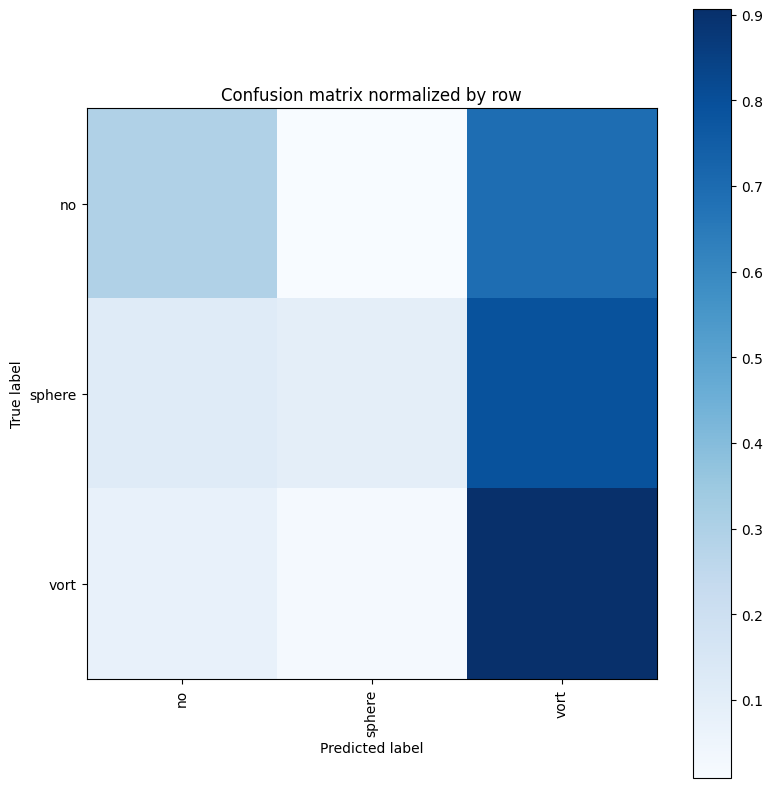

Overall accuracy: 0.432



train:   0%|          | 0/938 [00:00<?, ?batch/s]

val:   0%|          | 0/235 [00:00<?, ?batch/s]

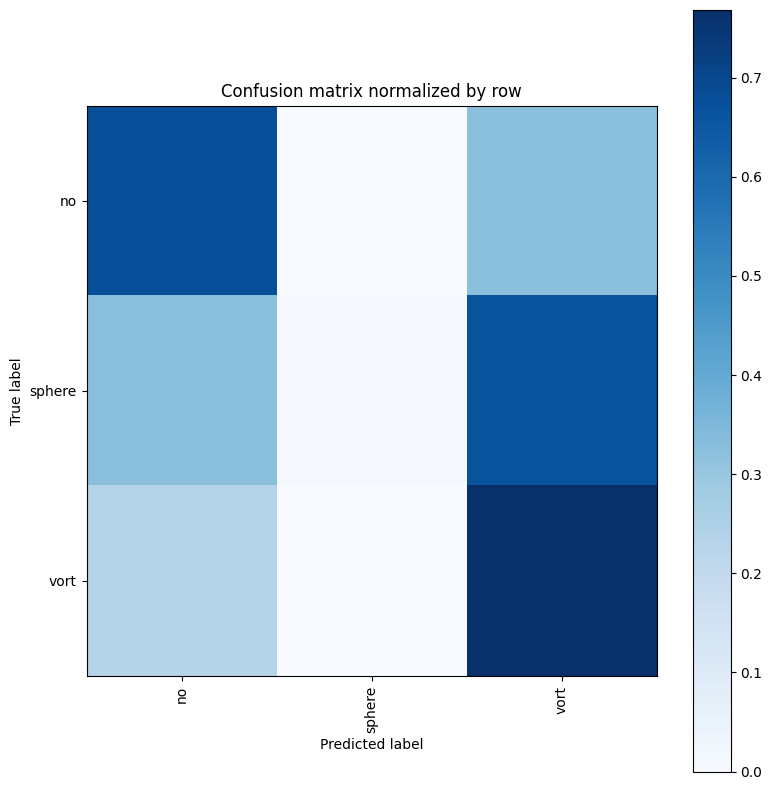

Overall accuracy: 0.484



train:   0%|          | 0/938 [00:00<?, ?batch/s]

val:   0%|          | 0/235 [00:00<?, ?batch/s]

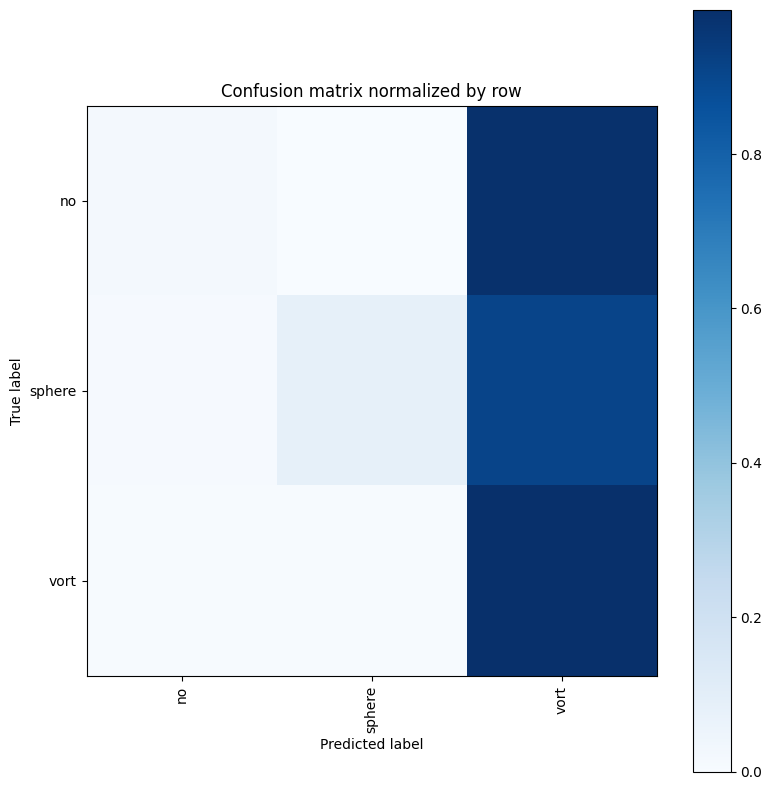

Overall accuracy: 0.364



train:   0%|          | 0/938 [00:00<?, ?batch/s]

val:   0%|          | 0/235 [00:00<?, ?batch/s]

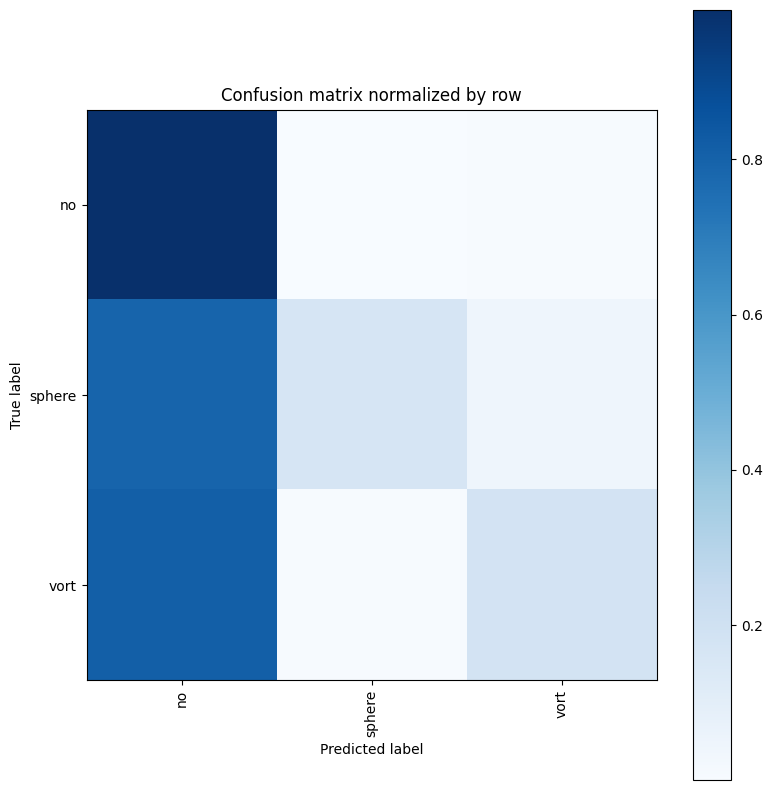

Overall accuracy: 0.446



train:   0%|          | 0/938 [00:00<?, ?batch/s]

val:   0%|          | 0/235 [00:00<?, ?batch/s]

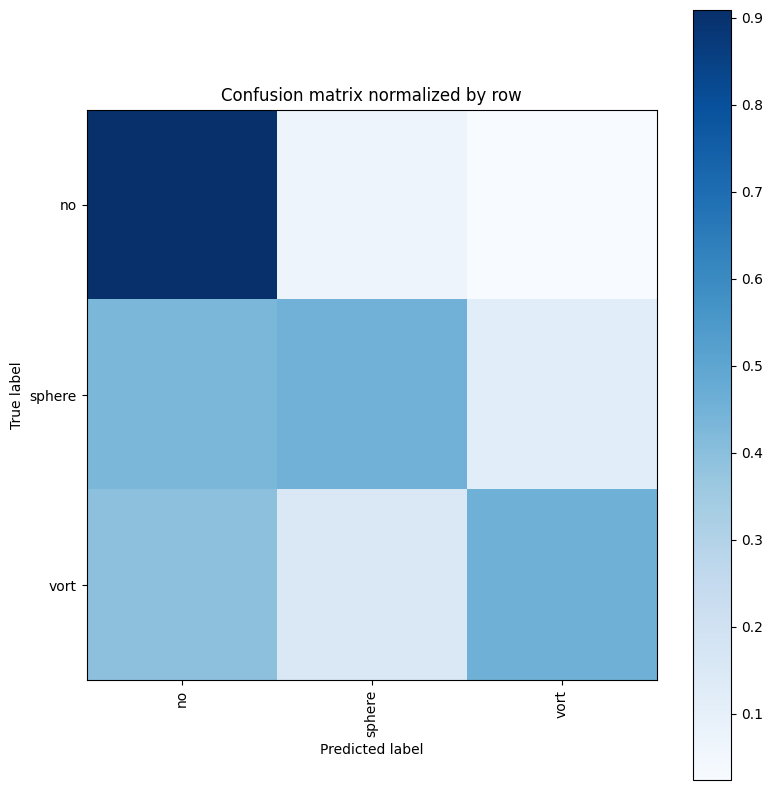

Overall accuracy: 0.606



train:   0%|          | 0/938 [00:00<?, ?batch/s]

val:   0%|          | 0/235 [00:00<?, ?batch/s]

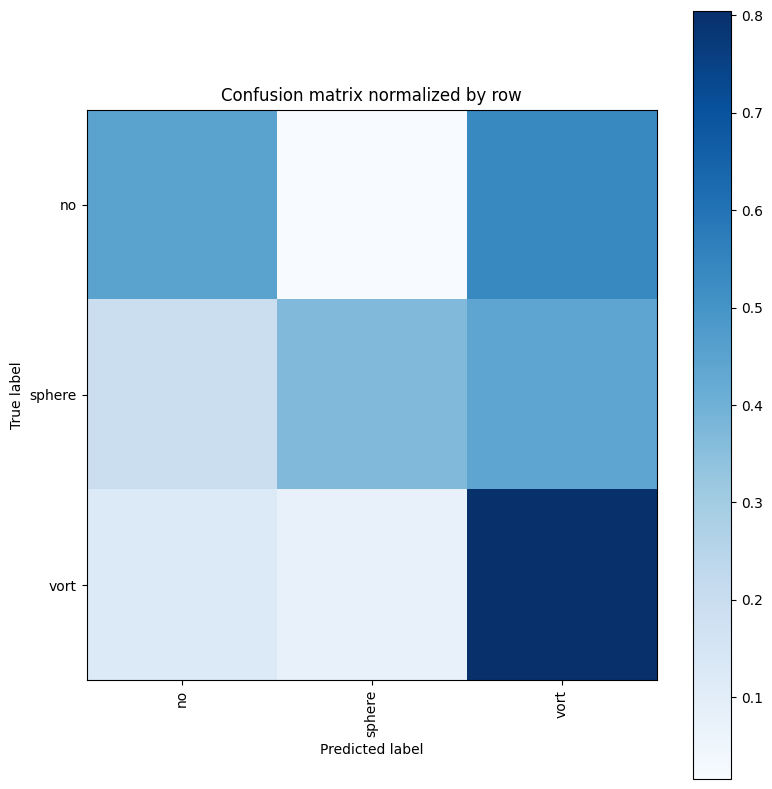

Overall accuracy: 0.541



train:   0%|          | 0/938 [00:00<?, ?batch/s]

val:   0%|          | 0/235 [00:00<?, ?batch/s]

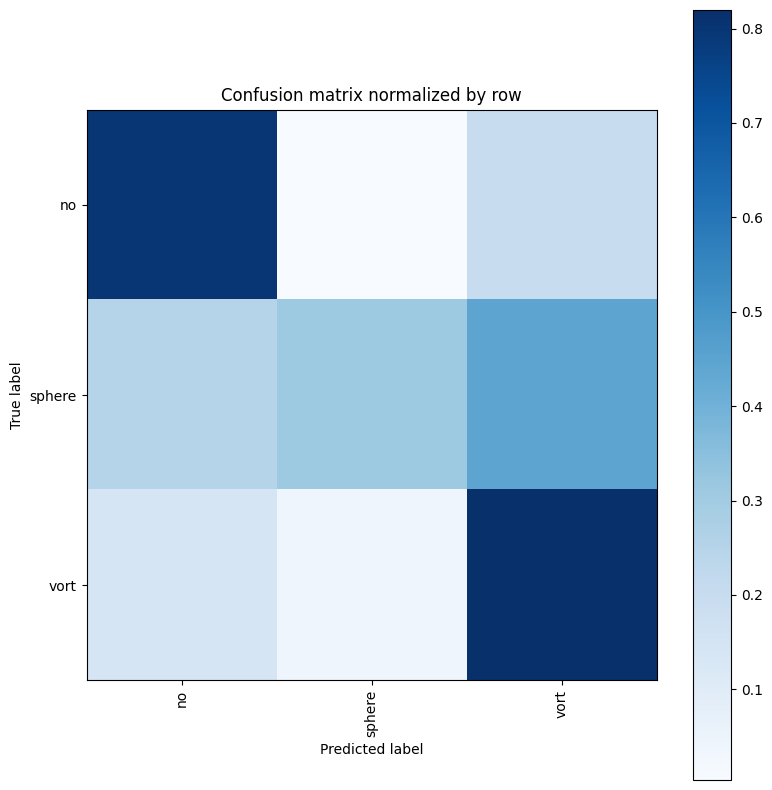

Overall accuracy: 0.643



train:   0%|          | 0/938 [00:00<?, ?batch/s]

val:   0%|          | 0/235 [00:00<?, ?batch/s]

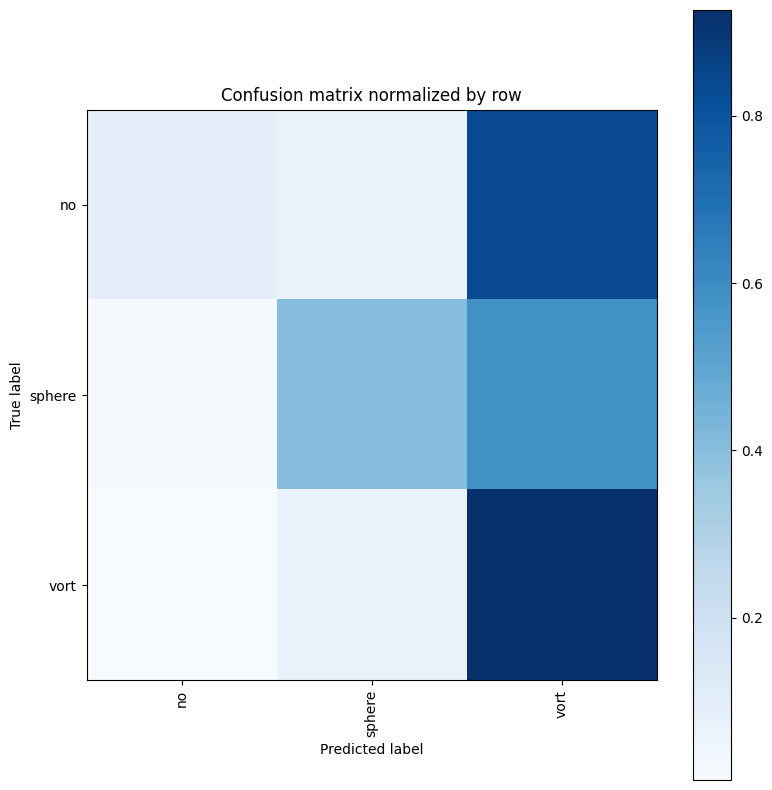

Overall accuracy: 0.475



train:   0%|          | 0/938 [00:00<?, ?batch/s]

val:   0%|          | 0/235 [00:00<?, ?batch/s]

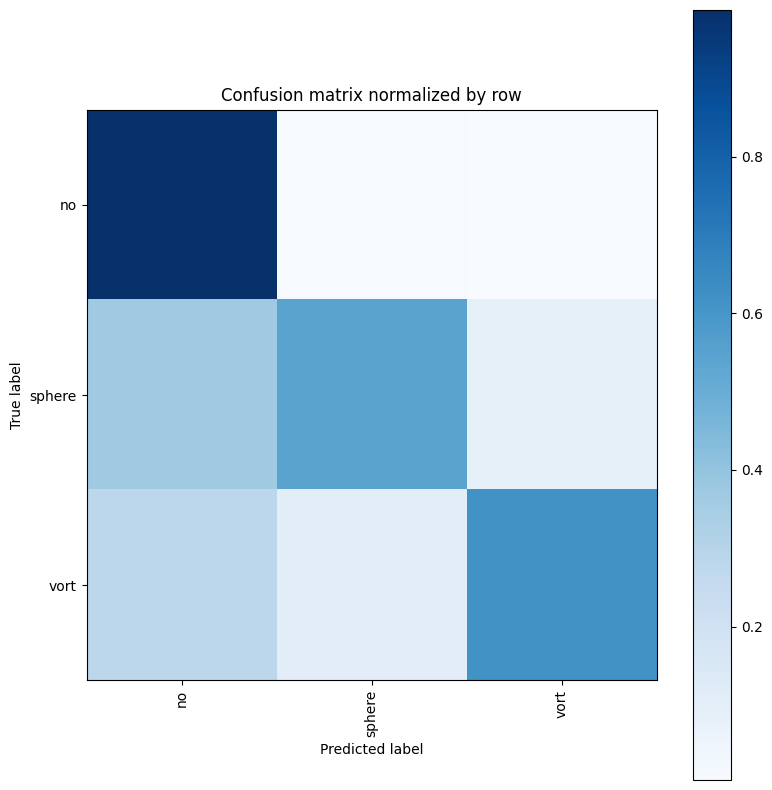

Overall accuracy: 0.716



train:   0%|          | 0/938 [00:00<?, ?batch/s]

val:   0%|          | 0/235 [00:00<?, ?batch/s]

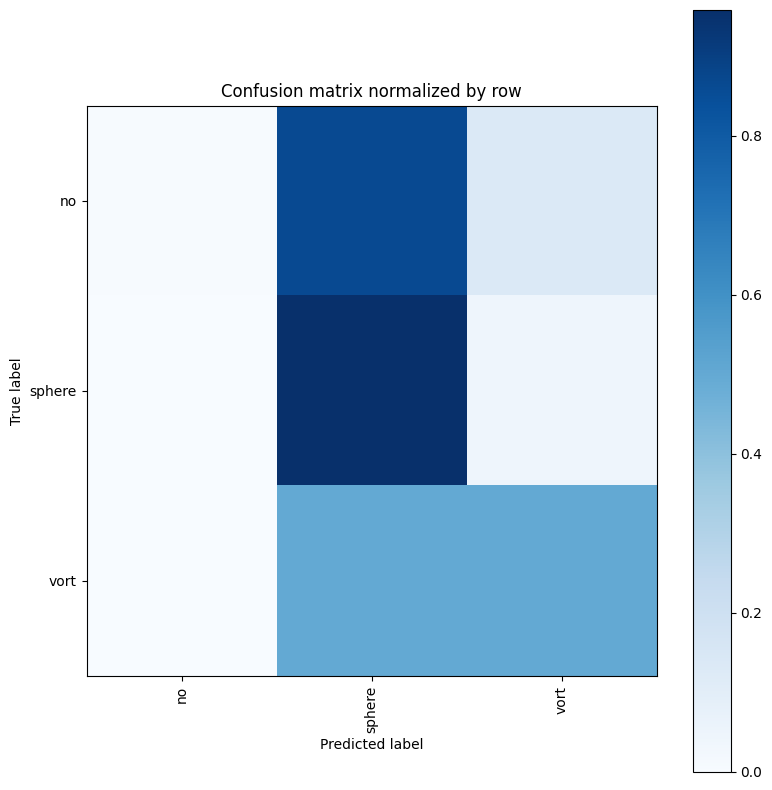

Overall accuracy: 0.487



train:   0%|          | 0/938 [00:00<?, ?batch/s]

val:   0%|          | 0/235 [00:00<?, ?batch/s]

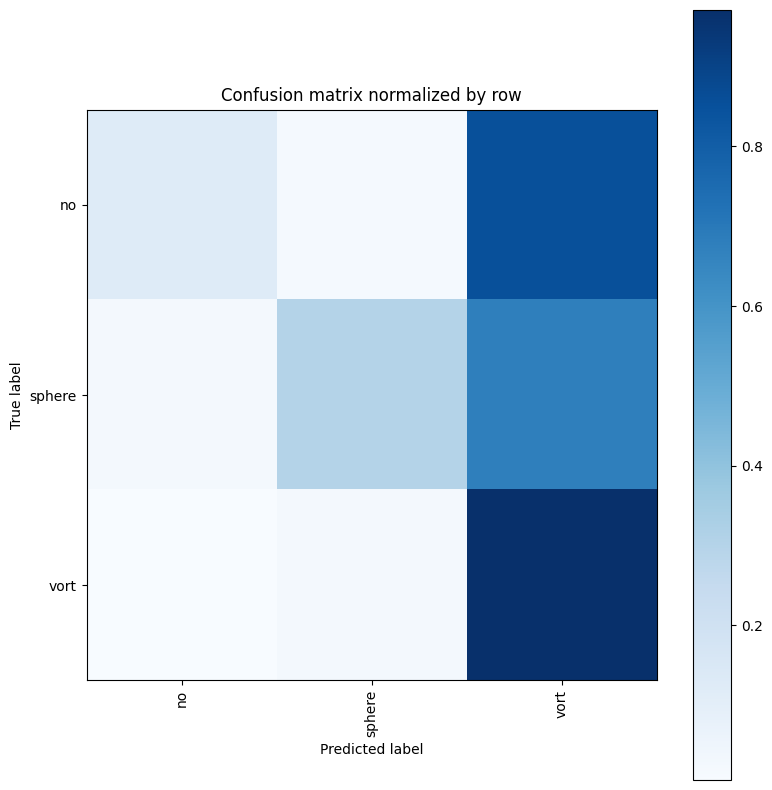

Overall accuracy: 0.466



train:   0%|          | 0/938 [00:00<?, ?batch/s]

val:   0%|          | 0/235 [00:00<?, ?batch/s]

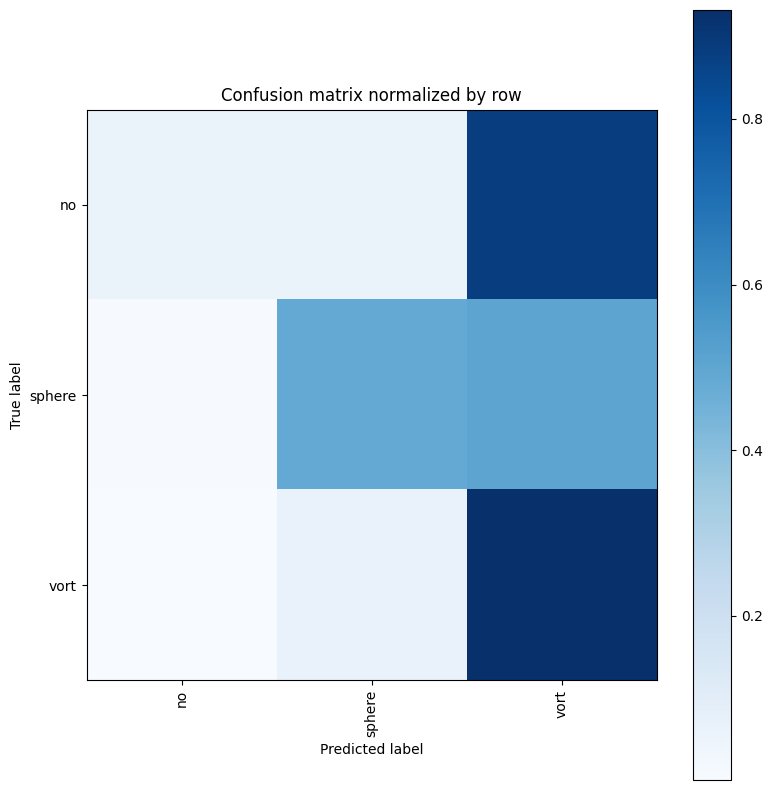

Overall accuracy: 0.493



train:   0%|          | 0/938 [00:00<?, ?batch/s]

val:   0%|          | 0/235 [00:00<?, ?batch/s]

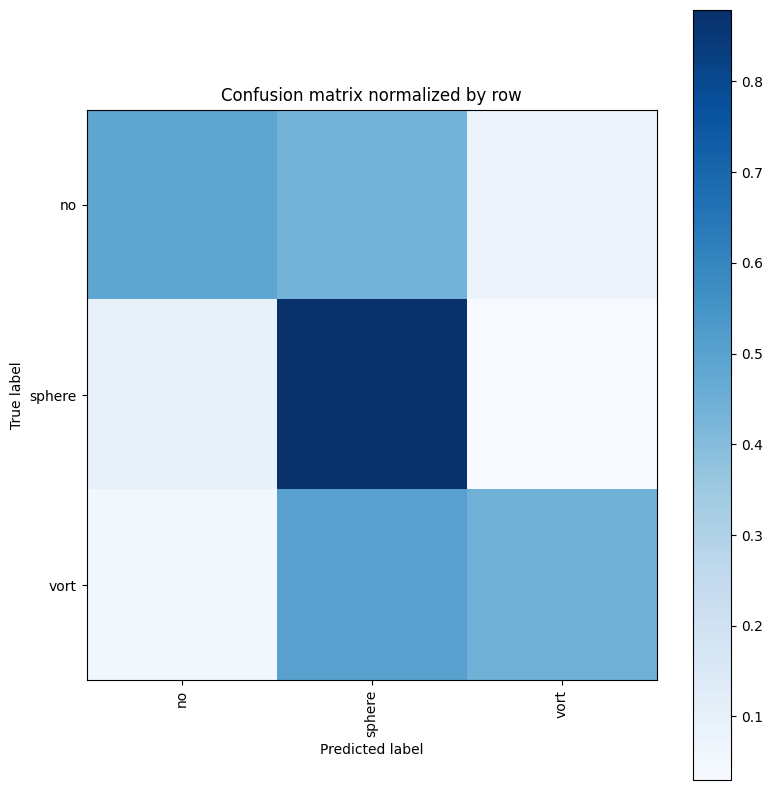

Overall accuracy: 0.603



train:   0%|          | 0/938 [00:00<?, ?batch/s]

val:   0%|          | 0/235 [00:00<?, ?batch/s]

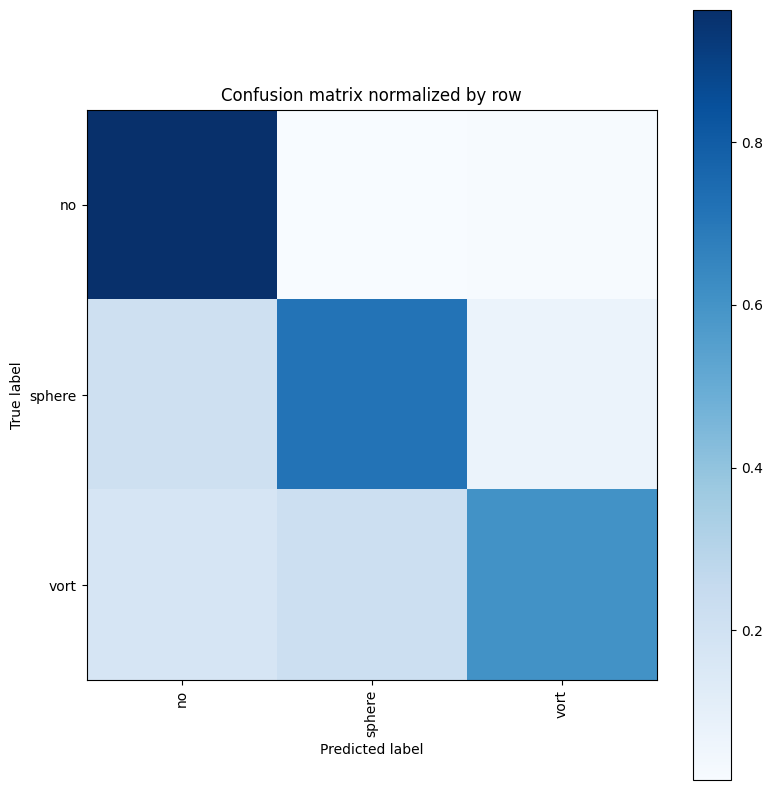

Overall accuracy: 0.761



train:   0%|          | 0/938 [00:00<?, ?batch/s]

Experiencing connection interruptions. Will try to reestablish communication with Neptune. Internal exception was: RequestsFutureAdapterConnectionError
Communication with Neptune restored!


val:   0%|          | 0/235 [00:00<?, ?batch/s]

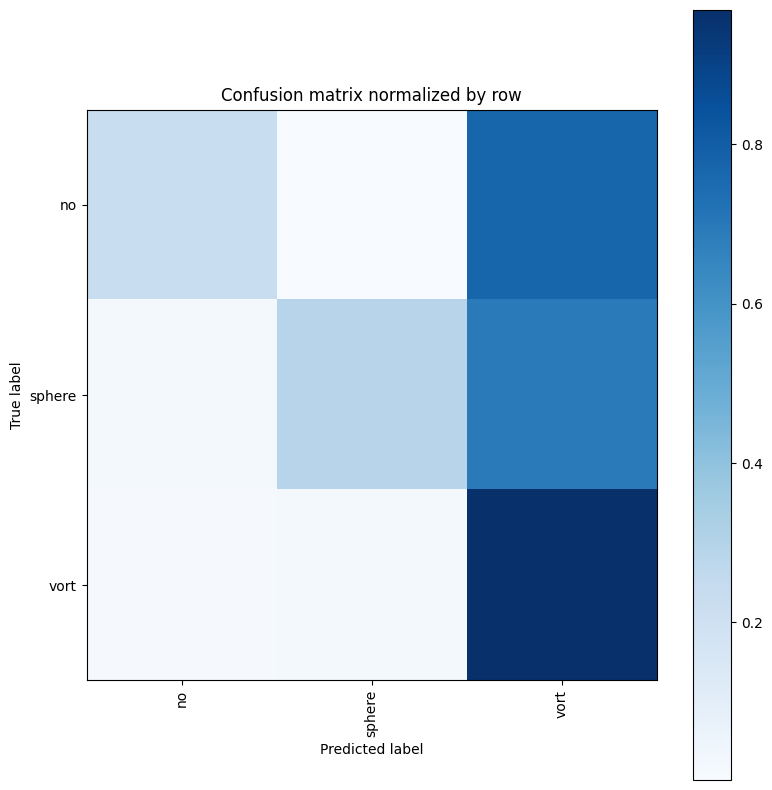

Overall accuracy: 0.493



train:   0%|          | 0/938 [00:00<?, ?batch/s]

Unexpected error occurred in Neptune background thread: Killing Neptune ping thread. Your run's status will not be updated and the run will be shown as inactive.


Exception in thread NeptunePing:
Traceback (most recent call last):
  File "e:\GSOC\.venv\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "e:\GSOC\.venv\lib\site-packages\urllib3\connectionpool.py", line 386, in _make_request
    self._validate_conn(conn)
  File "e:\GSOC\.venv\lib\site-packages\urllib3\connectionpool.py", line 1042, in _validate_conn
    conn.connect()
  File "e:\GSOC\.venv\lib\site-packages\urllib3\connection.py", line 472, in connect
    _match_hostname(cert, self.assert_hostname or server_hostname)
  File "e:\GSOC\.venv\lib\site-packages\urllib3\connection.py", line 545, in _match_hostname
    match_hostname(cert, asserted_hostname)
  File "e:\GSOC\.venv\lib\site-packages\urllib3\util\ssl_match_hostname.py", line 155, in match_hostname
    raise CertificateError("hostname %r doesn't match %r" % (hostname, dnsnames[0]))
urllib3.util.ssl_match_hostname.CertificateError: hostname 'new-ui.neptune.ai' d

val:   0%|          | 0/235 [00:00<?, ?batch/s]

Unexpected error occurred in Neptune background thread: Killing Neptune asynchronous thread. All data is safe on disk and can be later synced manually using `neptune sync` command.


Exception in thread NeptuneAsyncOpProcessor:
Traceback (most recent call last):
  File "e:\GSOC\.venv\lib\site-packages\urllib3\connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "e:\GSOC\.venv\lib\site-packages\urllib3\connectionpool.py", line 386, in _make_request
    self._validate_conn(conn)
  File "e:\GSOC\.venv\lib\site-packages\urllib3\connectionpool.py", line 1042, in _validate_conn
    conn.connect()
  File "e:\GSOC\.venv\lib\site-packages\urllib3\connection.py", line 472, in connect
    _match_hostname(cert, self.assert_hostname or server_hostname)
  File "e:\GSOC\.venv\lib\site-packages\urllib3\connection.py", line 545, in _match_hostname
    match_hostname(cert, asserted_hostname)
  File "e:\GSOC\.venv\lib\site-packages\urllib3\util\ssl_match_hostname.py", line 155, in match_hostname
    raise CertificateError("hostname %r doesn't match %r" % (hostname, dnsnames[0]))
urllib3.util.ssl_match_hostname.CertificateError: hostname 'new-ui.n

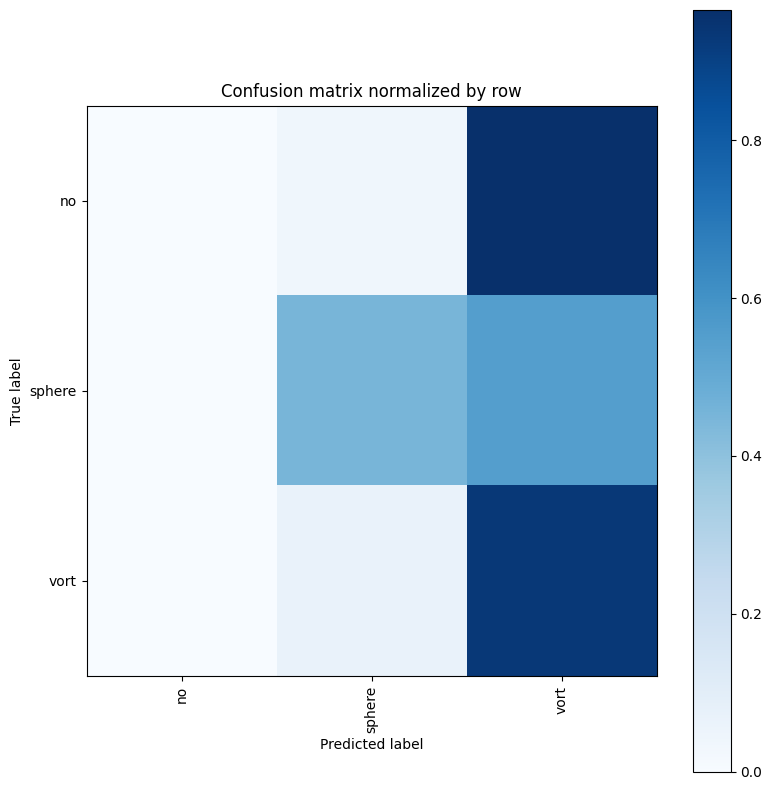

Overall accuracy: 0.461



train:   0%|          | 0/938 [00:00<?, ?batch/s]

val:   0%|          | 0/235 [00:00<?, ?batch/s]

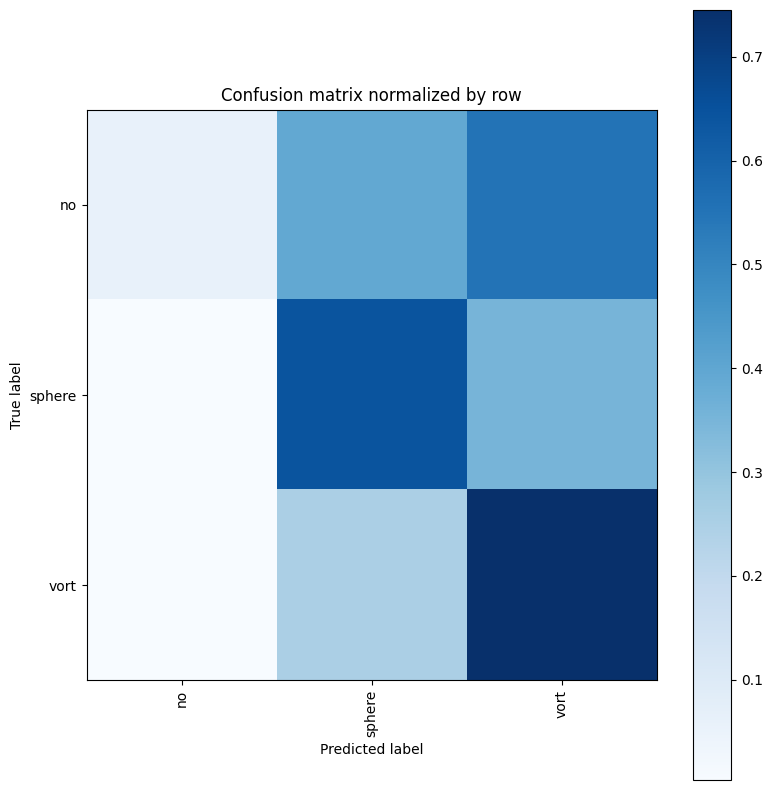

Overall accuracy: 0.481



train:   0%|          | 0/938 [00:00<?, ?batch/s]

val:   0%|          | 0/235 [00:00<?, ?batch/s]

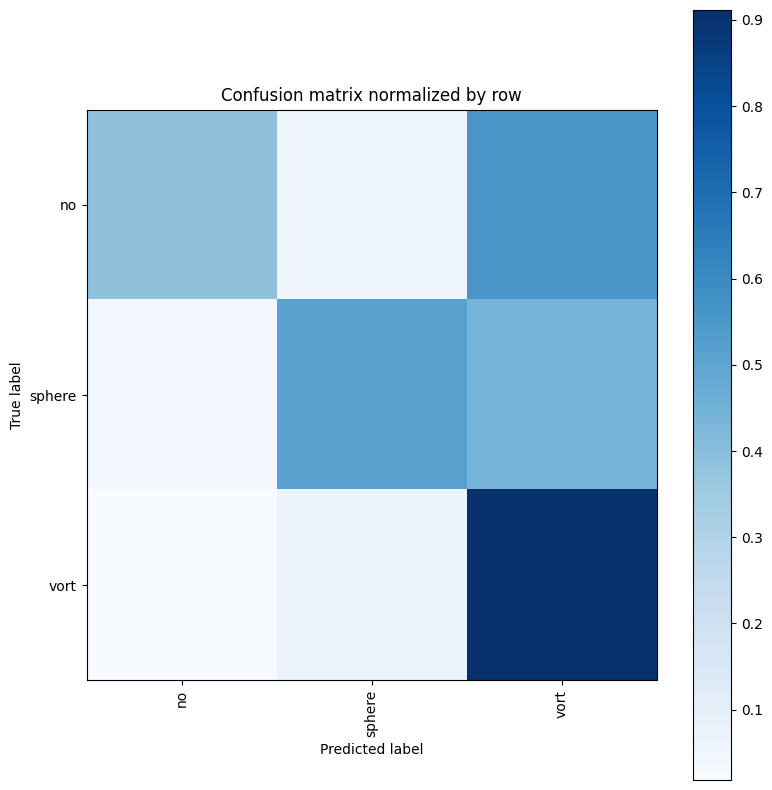

Overall accuracy: 0.605



train:   0%|          | 0/938 [00:00<?, ?batch/s]

val:   0%|          | 0/235 [00:00<?, ?batch/s]

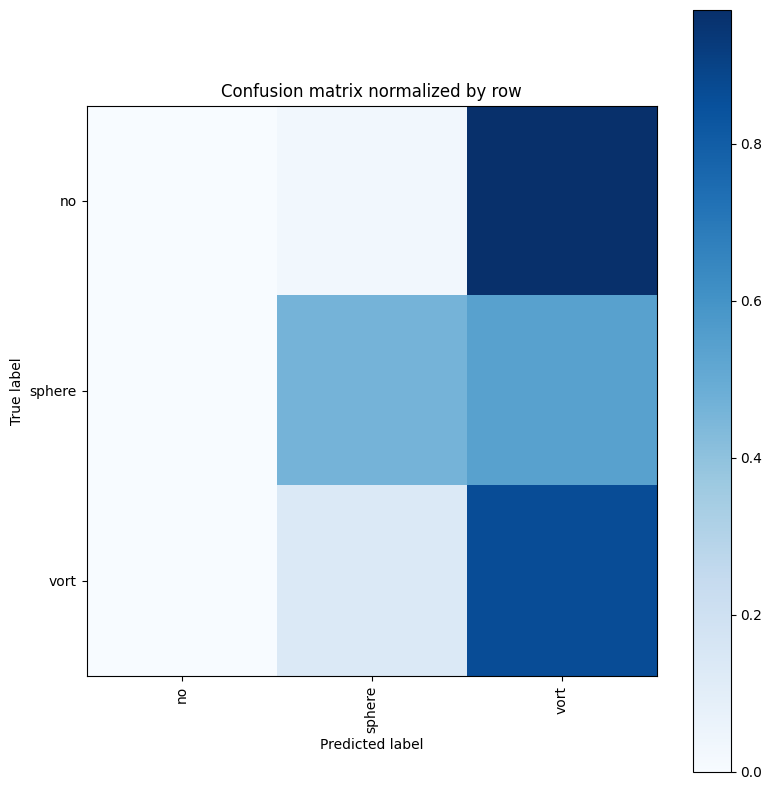

Overall accuracy: 0.441



train:   0%|          | 0/938 [00:00<?, ?batch/s]

val:   0%|          | 0/235 [00:00<?, ?batch/s]

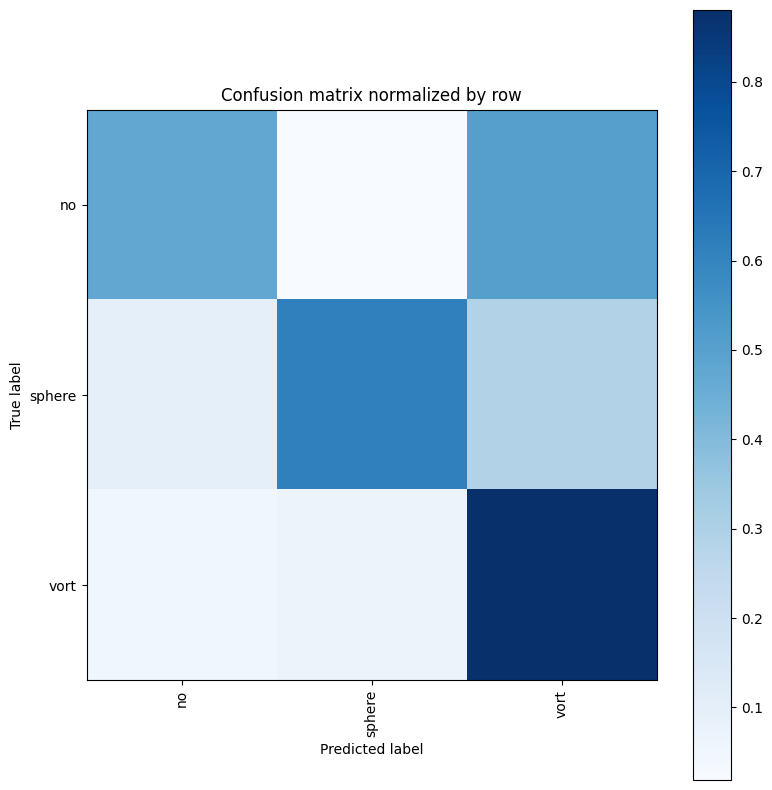

Overall accuracy: 0.656



train:   0%|          | 0/938 [00:00<?, ?batch/s]

val:   0%|          | 0/235 [00:00<?, ?batch/s]

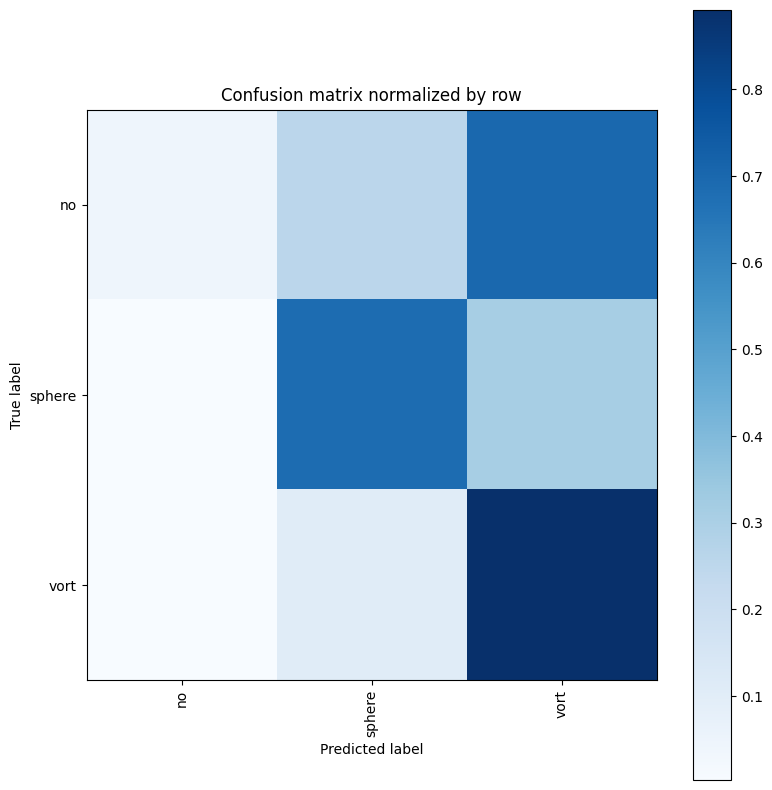

Overall accuracy: 0.541



train:   0%|          | 0/938 [00:00<?, ?batch/s]

val:   0%|          | 0/235 [00:00<?, ?batch/s]

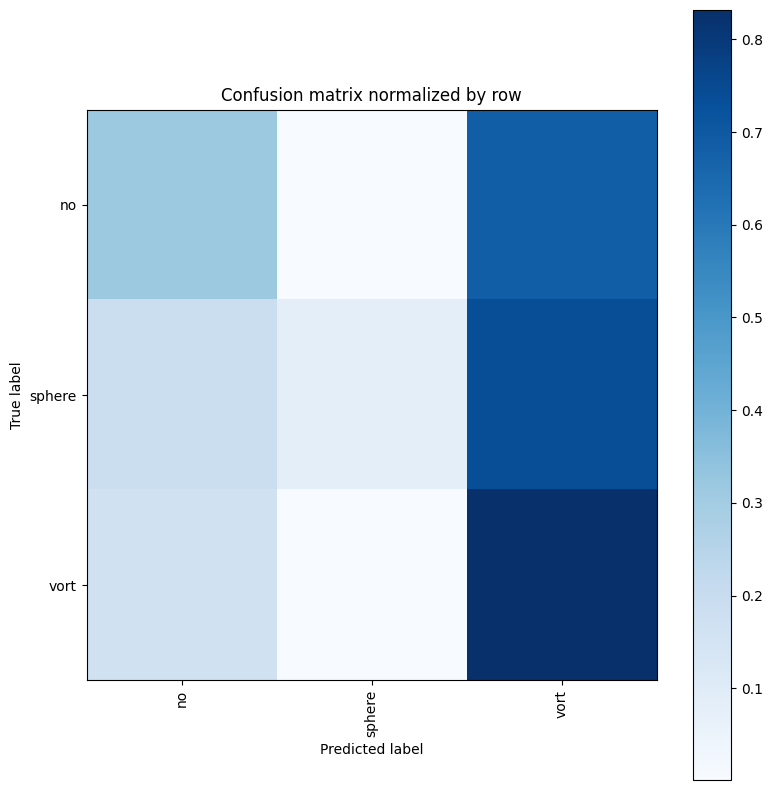

Overall accuracy: 0.409



train:   0%|          | 0/938 [00:00<?, ?batch/s]

val:   0%|          | 0/235 [00:00<?, ?batch/s]

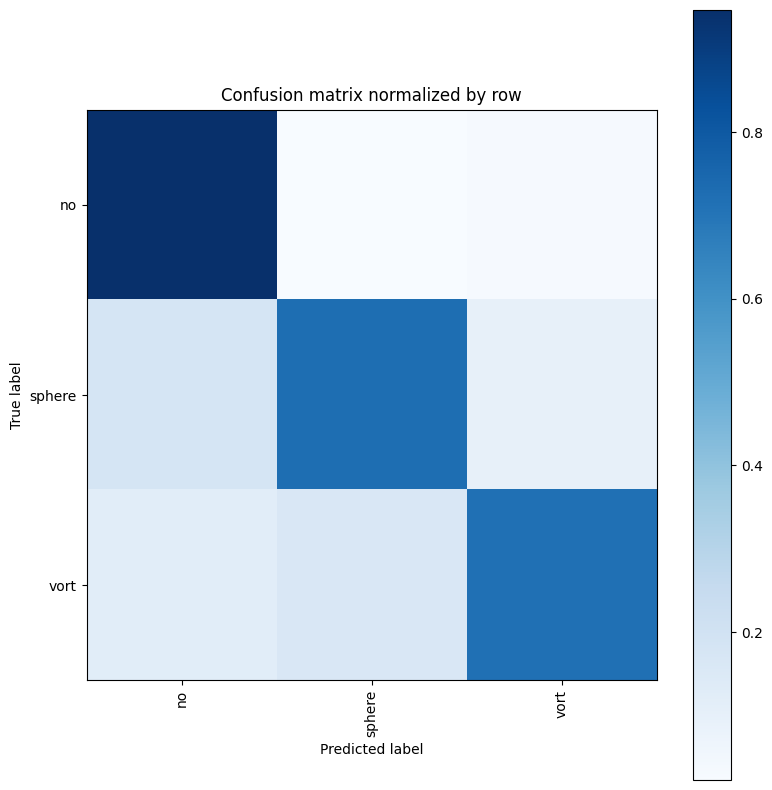

Overall accuracy: 0.796



train:   0%|          | 0/938 [00:00<?, ?batch/s]

val:   0%|          | 0/235 [00:00<?, ?batch/s]

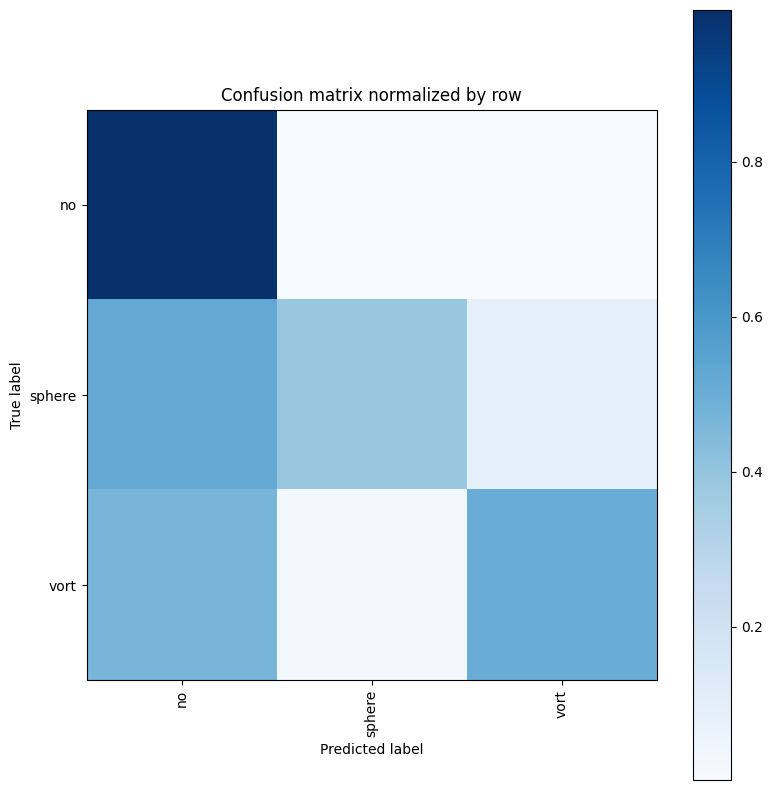

Overall accuracy: 0.630



train:   0%|          | 0/938 [00:00<?, ?batch/s]

val:   0%|          | 0/235 [00:00<?, ?batch/s]

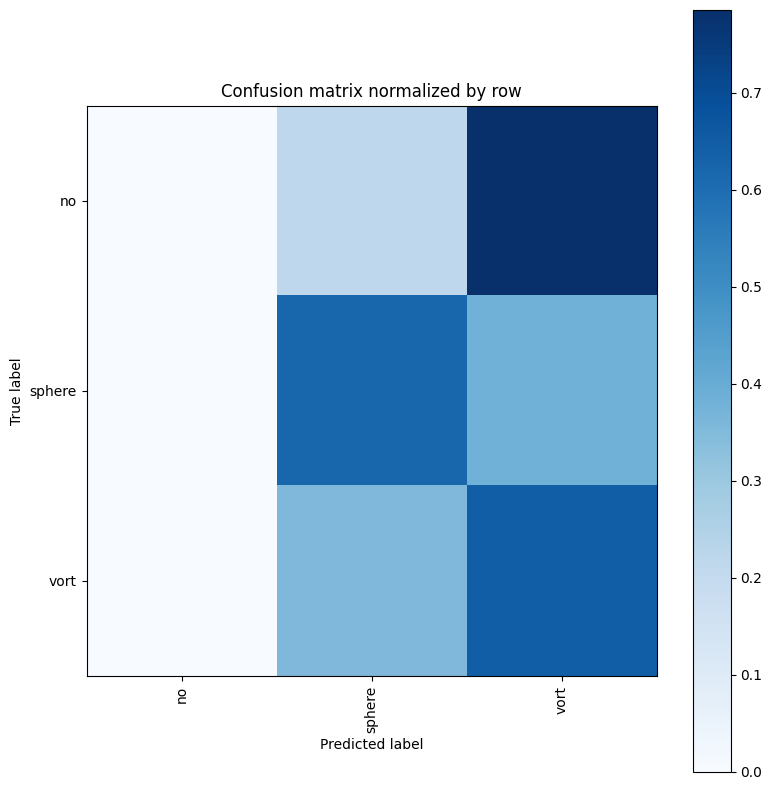

Overall accuracy: 0.422



train:   0%|          | 0/938 [00:00<?, ?batch/s]

val:   0%|          | 0/235 [00:00<?, ?batch/s]

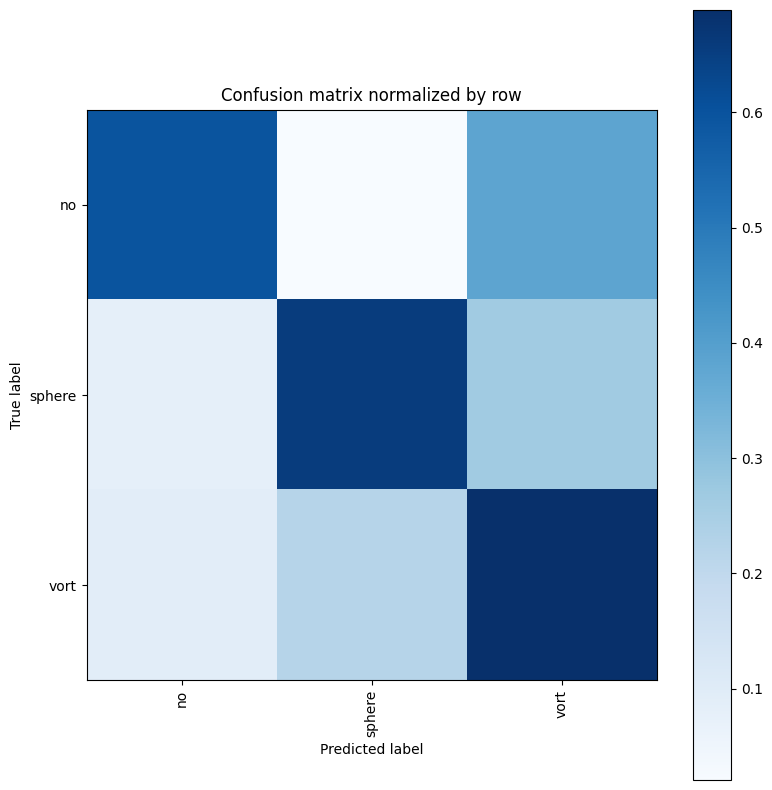

Overall accuracy: 0.647



train:   0%|          | 0/938 [00:00<?, ?batch/s]

val:   0%|          | 0/235 [00:00<?, ?batch/s]

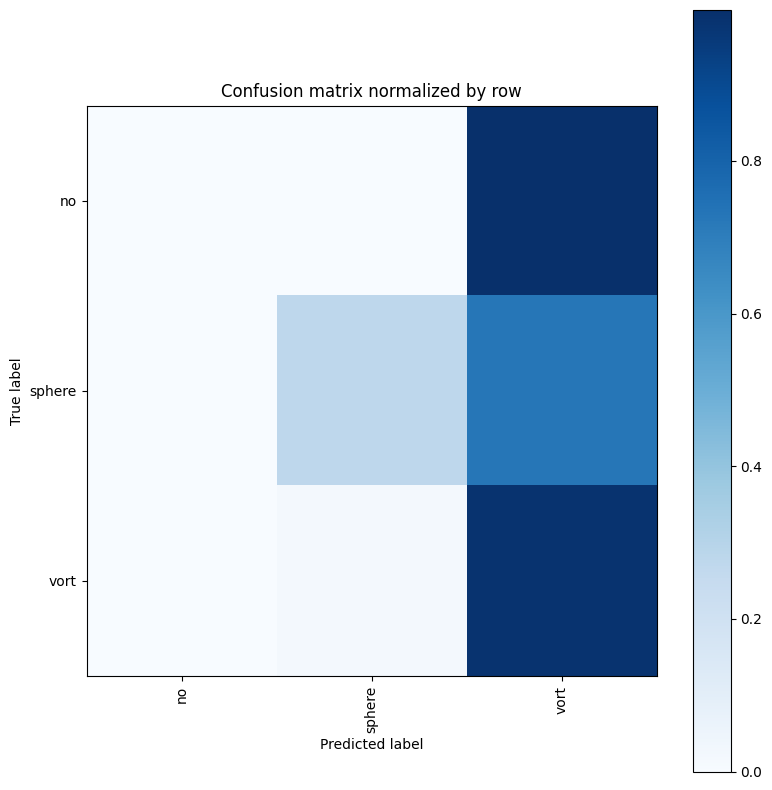

Overall accuracy: 0.420



train:   0%|          | 0/938 [00:00<?, ?batch/s]

val:   0%|          | 0/235 [00:00<?, ?batch/s]

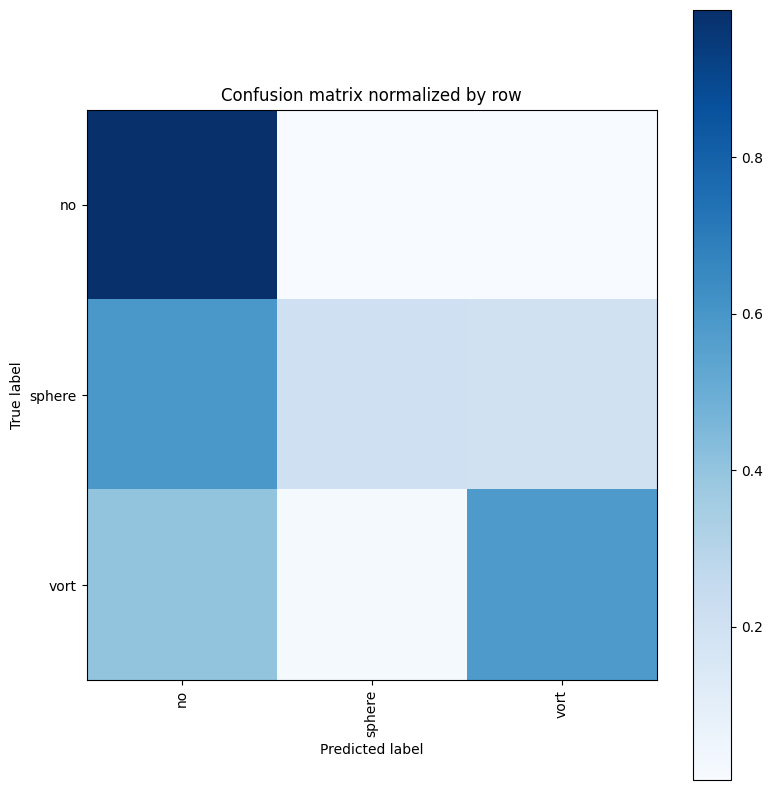

Overall accuracy: 0.593



train:   0%|          | 0/938 [00:00<?, ?batch/s]

val:   0%|          | 0/235 [00:00<?, ?batch/s]

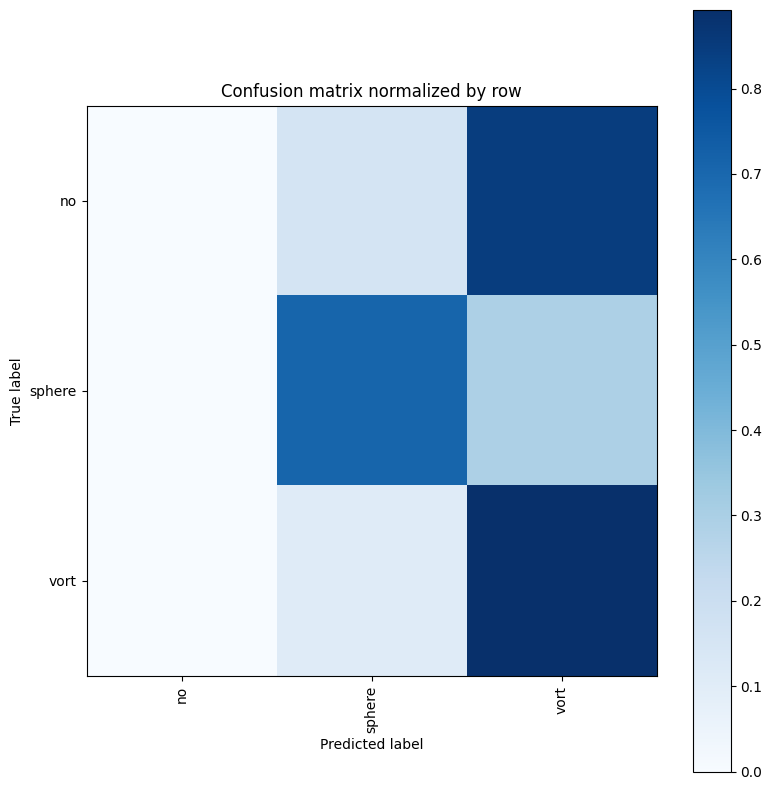

Overall accuracy: 0.534



train:   0%|          | 0/938 [00:00<?, ?batch/s]

val:   0%|          | 0/235 [00:00<?, ?batch/s]

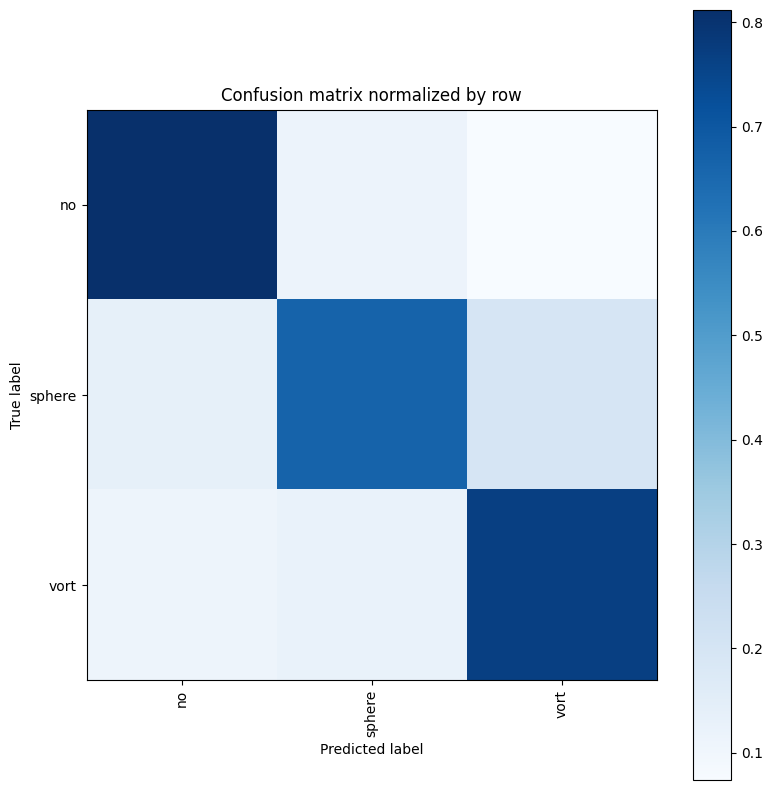

Overall accuracy: 0.748



train:   0%|          | 0/938 [00:00<?, ?batch/s]

val:   0%|          | 0/235 [00:00<?, ?batch/s]

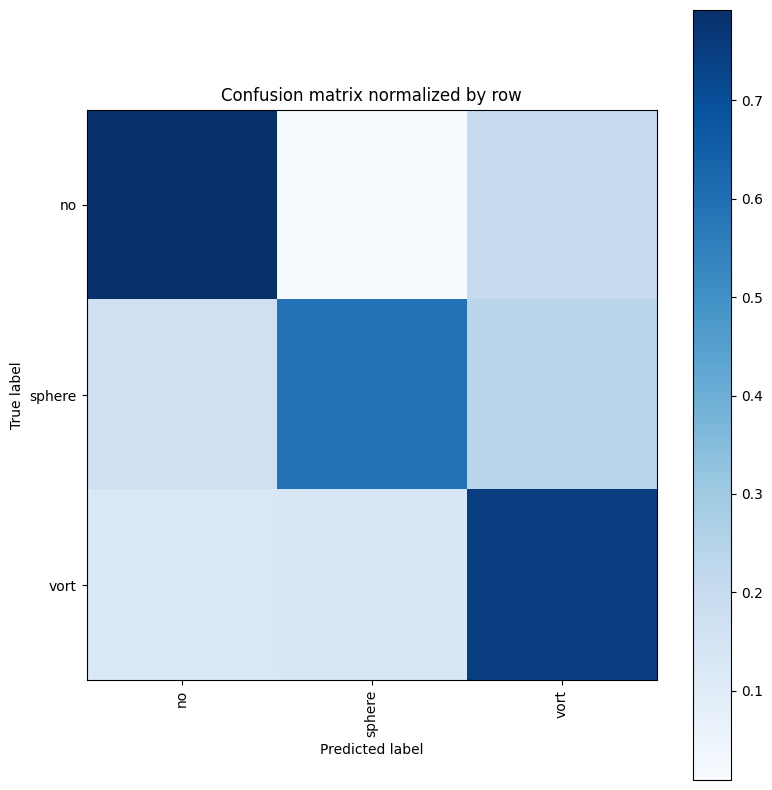

Overall accuracy: 0.711



train:   0%|          | 0/938 [00:00<?, ?batch/s]

val:   0%|          | 0/235 [00:00<?, ?batch/s]

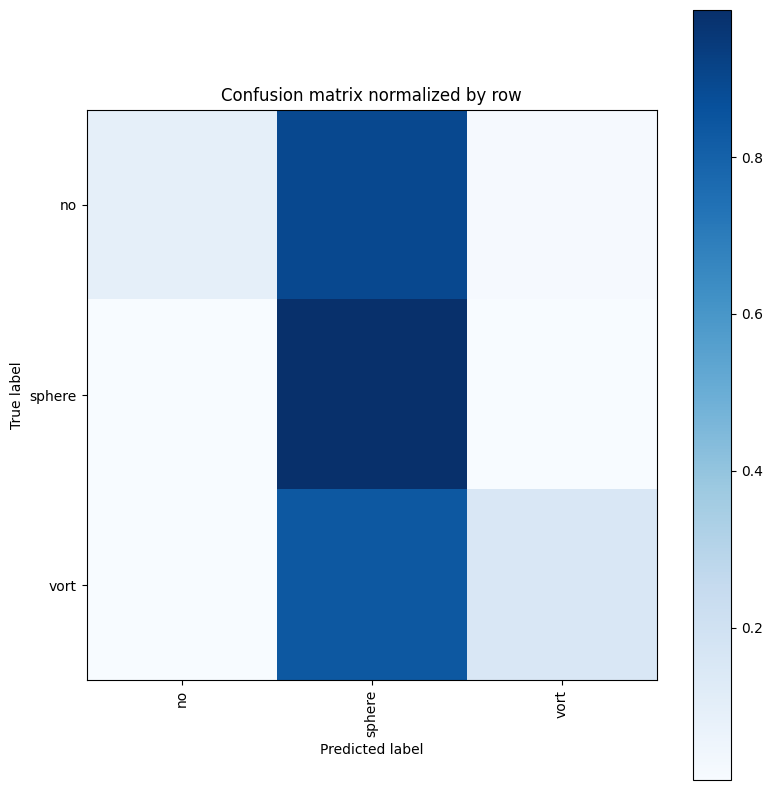

Overall accuracy: 0.412



train:   0%|          | 0/938 [00:00<?, ?batch/s]

val:   0%|          | 0/235 [00:00<?, ?batch/s]

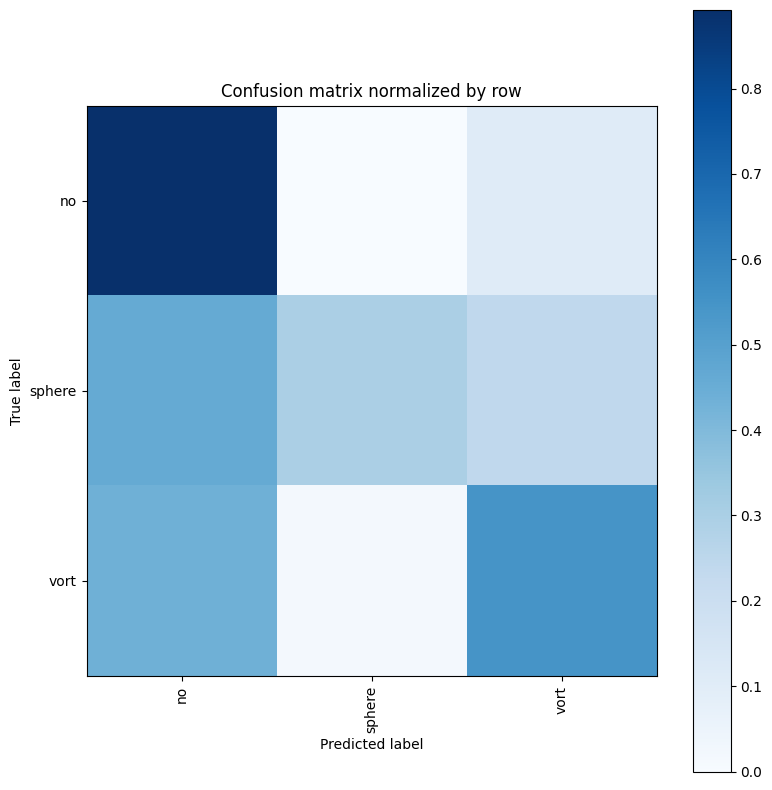

Overall accuracy: 0.578



train:   0%|          | 0/938 [00:00<?, ?batch/s]

val:   0%|          | 0/235 [00:00<?, ?batch/s]

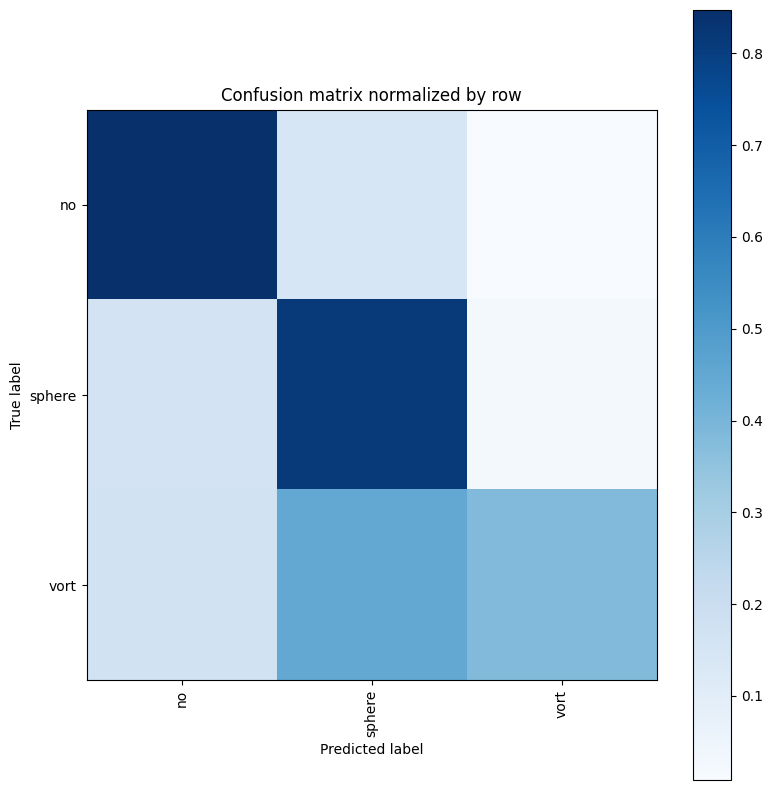

Overall accuracy: 0.681



train:   0%|          | 0/938 [00:00<?, ?batch/s]

val:   0%|          | 0/235 [00:00<?, ?batch/s]

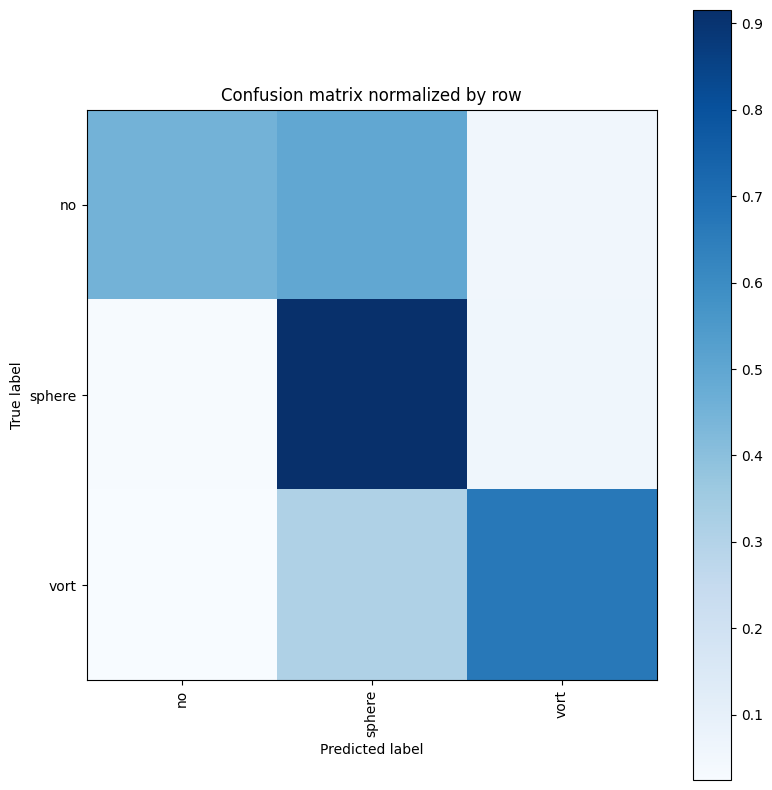

Overall accuracy: 0.677



train:   0%|          | 0/938 [00:00<?, ?batch/s]

val:   0%|          | 0/235 [00:00<?, ?batch/s]

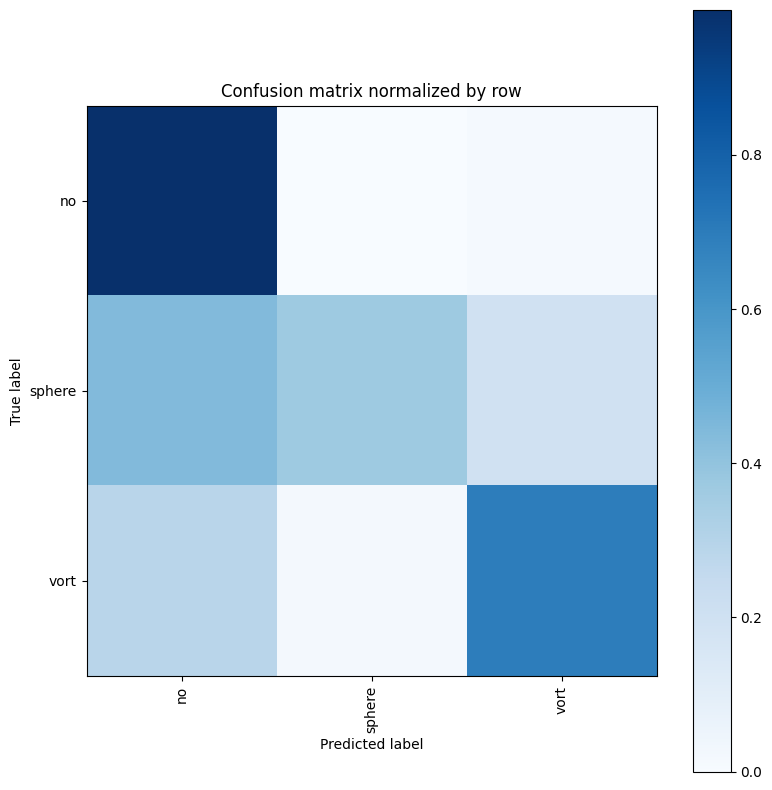

Overall accuracy: 0.683



train:   0%|          | 0/938 [00:00<?, ?batch/s]

val:   0%|          | 0/235 [00:00<?, ?batch/s]

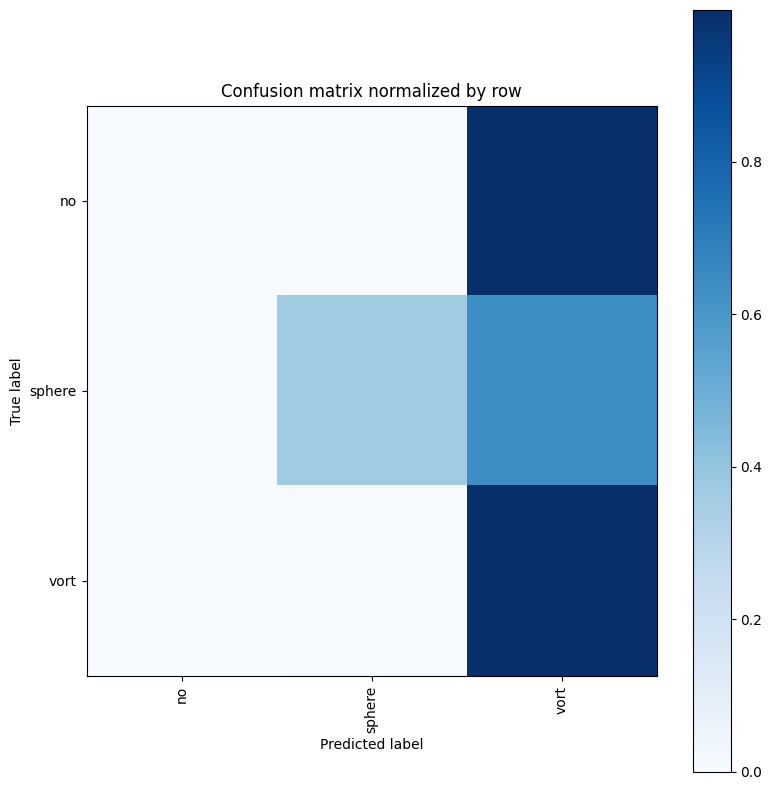

Overall accuracy: 0.453



train:   0%|          | 0/938 [00:00<?, ?batch/s]

In [34]:
best_acc = 0.0
train_data = []
for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):

    train_metrics = train_step(model, train_dl, optimizer, loss_modules, device, phase='train', loss_alpha=0.0001)
    train_metrics['epoch'] = epoch
    train_metrics['phase'] = 'train'
    train_data.append(train_metrics)
    log(i, 'train', train_metrics)

    eval_metrics = eval_step(model, val_dl, loss_modules, device, class_names=list(clsname2clsid.keys()), phase='val', loss_alpha=0.0001, print_report=False)
    eval_metrics['epoch'] = epoch 
    eval_metrics['phase'] = 'valid'
    train_data.append(eval_metrics)
    log(i, 'valid', train_metrics)
    # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
    # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
    if eval_metrics['accuracy'] > best_acc:
        best_model = copy.deepcopy(model.state_dict())
        
    if epoch%5 == 0:
        save_model(model,config['experiment title'],epoch)

train_df = pd.DataFrame().from_records(train_data)
plot_curves(train_df)

model.load_state_dict(best_model)